In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

### Volcano plots

In [2]:
comparisons = ['Kisumu_BusiaParental', 'BusiaParental_BusiaSelected']

In [6]:
diffexp_df = {}

nsig = pd.read_csv("../../freebayesresults/genediff/nsig_genes.tsv", sep="\t")

for comp in comparisons:

    diffexp_df[comp] = pd.read_csv(f"../../freebayesresults/genediff/{comp}.csv")
    
    nsig[f'{comp}_ngenes'][nsig.direction.str.contains("0.05")] = nsig[f'{comp}_ngenes'][nsig.direction.str.contains("0.05")].reset_index(drop=True) - nsig[f'{comp}_ngenes'][nsig.direction.str.contains("0.001")].reset_index(drop=True)

/home/sanj/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/sanj/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [7]:
nsig

,direction,Kisumu_BusiaParental_ngenes,BusiaParental_BusiaSelected_ngenes,Kisumu_BusiaSelected_ngenes
0,"Downregulated, padj = 0.05",1092,1067,3607
1,"Upregulated, padj = 0.05",1302,1557,3584
2,"Downregulated, padj = 0.001",1561,1858,2599
3,"Upregulated, padj = 0.001",1459,1171,2306


In [8]:
import allel


In [9]:
genes = allel.gff3_to_dataframe("../../resources/reference/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.12.gff3").query("type == 'gene'")
n_genes = genes.shape[0]

In [10]:
data = nsig.sort_values(by='direction')[f'{comp}_ngenes'].to_numpy()
data = np.append(data, n_genes-data.sum())

In [11]:
nsig

,direction,Kisumu_BusiaParental_ngenes,BusiaParental_BusiaSelected_ngenes,Kisumu_BusiaSelected_ngenes
0,"Downregulated, padj = 0.05",1092,1067,3607
1,"Upregulated, padj = 0.05",1302,1557,3584
2,"Downregulated, padj = 0.001",1561,1858,2599
3,"Upregulated, padj = 0.001",1459,1171,2306


In [43]:
def plotDonut(ax, data, n=None, text=True):
    if text == True:
        ax.pie(data, labels = ['Down \np<0.001', 'Down \np<0.05', 'Up \np<0.001', 'Up \np<0.05', ''], colors=['gold', 'lemonchiffon', 'limegreen', 'forestgreen', 'whitesmoke'])
    else:
        ax.pie(data, colors=['lemonchiffon', 'gold', 'limegreen', 'forestgreen', 'whitesmoke'])
    circle = matplotlib.patches.Circle( (0,0), 0.5, color='white')
    ax.add_patch(circle)
   # ax.set_facecolor('white')
    ax.add_artist(circle)

    ax.text(-0.2, -0.07, data[:-1].sum(), fontsize=14)
  #  ax.text(-2.45, -0.35, f"n={n}")


In [44]:
sets = ['cytochrome P450 [Source:VB Community Annotation', 'carboxylesterase [Source:VB Community Annotation]', 'glutathione S-transferase']

In [45]:
metabolic = pd.read_csv("../../resources/annotation/type1_metabolic.txt", sep="\t").rename(columns={'Gene stable ID':'GeneID'})

/home/sanj/apps/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/sanj/apps/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


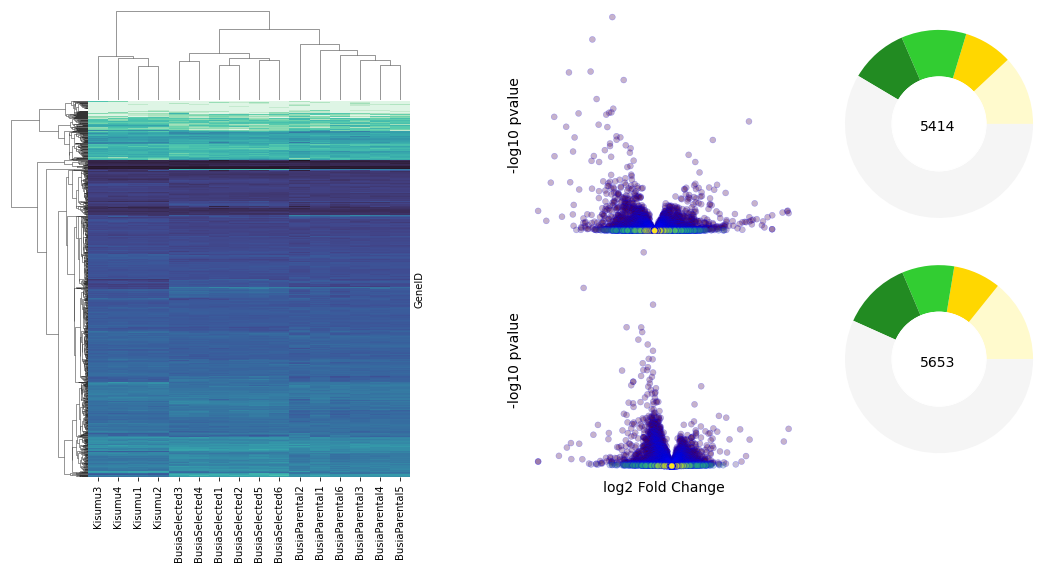

In [71]:
df = pd.read_csv("../../results/quant/normCounts.tsv", sep="\t")
#df = df.query("GeneID in @metabolic.GeneID")
df = df.set_index('GeneID').apply(lambda x: x+1).apply(np.log2)[:1000]


#First create the clustermap figure
g = sns.clustermap(data=df, cmap="mako_r", figsize=[16,8], yticklabels="")
g.cax.set_visible(False)
# set the gridspec to only cover half of the figure
g.gs.update(left=0.05, right=0.4)
#create new gridspec for the right part
gs2 = matplotlib.gridspec.GridSpec(2,2, left=0.5)
# create axes within this new gridspec
ax = g.fig.add_subplot(gs2[0,0]), g.fig.add_subplot(gs2[1,0]), g.fig.add_subplot(gs2[0,1]), g.fig.add_subplot(gs2[1,1])

for idx, comp in enumerate(comparisons):
    df = diffexp_df[comp].query("log2FoldChange > -12 & log2FoldChange < 15").copy()
    df.loc[:, 'pval_volcano'] = -np.log10(df.loc[:, 'padj'])
    sns.scatterplot(ax=ax[idx], x="log2FoldChange", y="pval_volcano", data=df, hue='padj', palette="viridis", alpha=0.3, edgecolor='b')
    ax[idx].set_ylabel(ylabel="-log10 pvalue", fontsize=14)
    ax[idx].set_xlabel(xlabel="log2 Fold Change", fontsize=14)
    sns.despine(left=True, bottom=True)
    _lg = ax[idx].get_legend()
    _lg.remove()    

    data = nsig.sort_values(by='direction')[f'{comp}_ngenes'].to_numpy()
    data = np.append(data, n_genes-data.sum())
    plotDonut(ax=ax[idx+2], data=data, text=False)    

for axes in ax:
        axes.set_yticklabels("")
        axes.set_yticks([])
        axes.set_xticks([])

g.savefig("../../docs/figures/diffExp.png", dpi=300)


- Insert curved line below donut plot indicating DE genes.
